In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import io
import re
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import import_ipynb
# from custom_matching_layers import *
from sklearn.model_selection import train_test_split
import json

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

In [3]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=gpus[0], device_type='GPU')
tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

## Preprocessing

In [4]:
print(os.listdir("./datasets"))
print(os.listdir("./datasets/QQP"))

['MSRP', 'SICK', 'QQP']
['quora_duplicate_questions.tsv']


In [9]:
df_msrp = pd.read_csv('./datasets/QQP/quora_duplicate_questions.tsv',delimiter='\t')

In [10]:
df_msrp

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [11]:
folder_bert = '../bert_en_uncased_L-12_H-768_A-12_3'
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(folder_bert, "assets/vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [12]:
tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['hello', 'tensor', '##flow', '!']
[7592, 23435, 12314, 999]


In [13]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [14]:
def encode_sentence(s):
    try:
        tokens = list(tokenizer.tokenize(str(s)))
        tokens.append('[SEP]')
        return tokenizer.convert_tokens_to_ids(tokens)
    except Exception as e:
        print(s)

tqdm.pandas()
df_msrp['question1_tokenized'] = df_msrp['question1'].progress_apply(lambda x: encode_sentence(x))
df_msrp['question2_tokenized'] = df_msrp['question2'].progress_apply(lambda x: encode_sentence(x))

df_msrp['len_q1'] = df_msrp['question1_tokenized'].map(lambda x: len(x))
df_msrp['len_q2'] = df_msrp['question2_tokenized'].map(lambda x: len(x))

/home/pranav/.local/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 404290/404290 [00:54<00:00, 7470.96it/s]


In [15]:
df_msrp.describe()

,id,qid1,qid2,is_duplicate,len_q1,len_q2
count,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198,14.600171,14.811841
std,116708.614503,157751.700002,159903.182629,0.482588,6.832226,7.802559
min,0.000000,1.000000,2.000000,0.000000,2.000000,2.000000
25%,101072.250000,74437.500000,74727.000000,0.000000,10.000000,10.000000
50%,202144.500000,192182.000000,197052.000000,0.000000,13.000000,13.000000
75%,303216.750000,346573.500000,354692.500000,1.000000,17.000000,17.000000
max,404289.000000,537932.000000,537933.000000,1.000000,154.000000,285.000000


In [16]:
df_msrp.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_tokenized,question2_tokenized,len_q1,len_q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[2054, 2003, 1996, 3357, 2011, 3357, 5009, 200...","[2054, 2003, 1996, 3357, 2011, 3357, 5009, 200...",16,14
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[2054, 2003, 1996, 2466, 1997, 12849, 10606, 1...","[2054, 2052, 4148, 2065, 1996, 2796, 2231, 103...",20,25
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[2129, 2064, 1045, 3623, 1996, 3177, 1997, 202...","[2129, 2064, 4274, 3177, 2022, 3445, 2011, 237...",17,13
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[2339, 2572, 1045, 10597, 2200, 9479, 1029, 21...","[2424, 1996, 6893, 2043, 1031, 8785, 1033, 260...",14,24
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[2029, 2028, 21969, 1999, 2300, 21864, 2243, 2...","[2029, 3869, 2052, 5788, 1999, 5474, 2300, 102...",19,9


In [17]:
df_msrp.to_pickle("./qqp_tokenized.pkl")

## Building Data

In [5]:
df_msrp = pd.read_pickle("./qqp_tokenized.pkl")

In [6]:
sentence_len = 26
df_msrp = df_msrp[(df_msrp['len_q1']<sentence_len) & (df_msrp['len_q2']<sentence_len)]

In [7]:
df_msrp

,id,qid1,qid2,question1,question2,is_duplicate,question1_tokenized,question2_tokenized,len_q1,len_q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[2054, 2003, 1996, 3357, 2011, 3357, 5009, 200...","[2054, 2003, 1996, 3357, 2011, 3357, 5009, 200...",16,14
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[2054, 2003, 1996, 2466, 1997, 12849, 10606, 1...","[2054, 2052, 4148, 2065, 1996, 2796, 2231, 103...",20,25
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[2129, 2064, 1045, 3623, 1996, 3177, 1997, 202...","[2129, 2064, 4274, 3177, 2022, 3445, 2011, 237...",17,13
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[2339, 2572, 1045, 10597, 2200, 9479, 1029, 21...","[2424, 1996, 6893, 2043, 1031, 8785, 1033, 260...",14,24
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[2029, 2028, 21969, 1999, 2300, 21864, 2243, 2...","[2029, 3869, 2052, 5788, 1999, 5474, 2300, 102...",19,9
...,...,...,...,...,...,...,...,...,...,...
404284,404284,537926,537927,What does Jainism say about homosexuality?,What does Jainism say about Gays and Homosexua...,1,"[2054, 2515, 17136, 2964, 2360, 2055, 15949, 1...","[2054, 2515, 17136, 2964, 2360, 2055, 5637, 20...",9,12
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0,"[2129, 2116, 3145, 22104, 2024, 2045, 1999, 19...","[2129, 2116, 3145, 22104, 2024, 2045, 1999, 25...",18,17
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1,"[2079, 2017, 2903, 2045, 2003, 2166, 2044, 233...","[2003, 2009, 2995, 2008, 2045, 2003, 2166, 204...",10,11
404287,404287,537928,537929,What is one coin?,What's this coin?,0,"[2054, 2003, 2028, 9226, 1029, 102]","[2054, 1005, 1055, 2023, 9226, 1029, 102]",6,7


In [8]:
def bert_encode(data):
    sentence1 = tf.ragged.constant(data['question1_tokenized'])
    sentence2 = tf.ragged.constant(data['question2_tokenized'])
    
    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
    input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

    input_mask = tf.ones_like(input_word_ids).to_tensor()

    type_cls = tf.zeros_like(cls)
    type_s1 = tf.zeros_like(sentence1)
    type_s2 = tf.ones_like(sentence2)
    input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()
    inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}
    return inputs

In [9]:
train_msrp, test_msrp = train_test_split(df_msrp, test_size=0.2)

In [10]:
folder_bert = '../bert_en_uncased_L-12_H-768_A-12_3'
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(folder_bert, "assets/vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [11]:
msrp_train = bert_encode(train_msrp)
msrp_train_labels = train_msrp['is_duplicate']

msrp_test = bert_encode(test_msrp)
msrp_test_labels = test_msrp['is_duplicate']

In [12]:
for key, value in msrp_train.items():
    print(f'{key:15s} shape: {value.shape}')

print(f'Train_labels shape: {msrp_train_labels.shape}')

input_word_ids  shape: (281612, 51)
input_mask      shape: (281612, 51)
input_type_ids  shape: (281612, 51)
Train_labels shape: (281612,)


## Build Model

In [13]:
hub_encoder = hub.KerasLayer(folder_bert,trainable=True)

In [14]:
print(f"The Hub encoder has {len(hub_encoder.trainable_variables)} trainable variables")

The Hub encoder has 199 trainable variables


In [15]:
result = hub_encoder(
    inputs = dict(
    input_word_ids=msrp_train['input_word_ids'][:10],
    input_mask=msrp_train['input_mask'][:10],
    input_type_ids=msrp_train['input_type_ids'][:10],),
    training=False,
)

In [16]:
result.keys()

dict_keys(['default', 'encoder_outputs', 'pooled_output', 'sequence_output'])

In [17]:
result['pooled_output']

<tf.Tensor: shape=(10, 768), dtype=float32, numpy=
array([[-0.99299586, -0.9187648 , -0.999855  , ..., -0.9957494 ,
        -0.9529475 ,  0.99098426],
       [-0.98894083, -0.9220566 , -0.99977434, ..., -0.99624324,
        -0.9566992 ,  0.9759701 ],
       [-0.9931428 , -0.940597  , -0.9999279 , ..., -0.99925077,
        -0.956974  ,  0.990779  ],
       ...,
       [-0.9892595 , -0.90791845, -0.99982065, ..., -0.9970311 ,
        -0.94855225,  0.98014224],
       [-0.99096406, -0.93077976, -0.9999052 , ..., -0.9980329 ,
        -0.9640674 ,  0.98329693],
       [-0.98962075, -0.8569541 , -0.999592  , ..., -0.9900181 ,
        -0.9375628 ,  0.98353904]], dtype=float32)>

In [18]:
bert_inputs = dict(
    input_word_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
    input_mask=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
    input_type_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
)

In [19]:
bert_output = hub_encoder(bert_inputs)

In [20]:
bert_classifier = layers.Dropout(.1)(bert_output['pooled_output'])
bert_classifier = x = layers.Dense(2, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=.02))(bert_classifier)

In [21]:
model = keras.Model(inputs=bert_inputs, outputs=bert_classifier, name="Bert_model")
model.summary()

Model: "Bert_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'encoder_outputs':  109482241   input_2[0][0]                    
                                                                 input_3[0][0]           

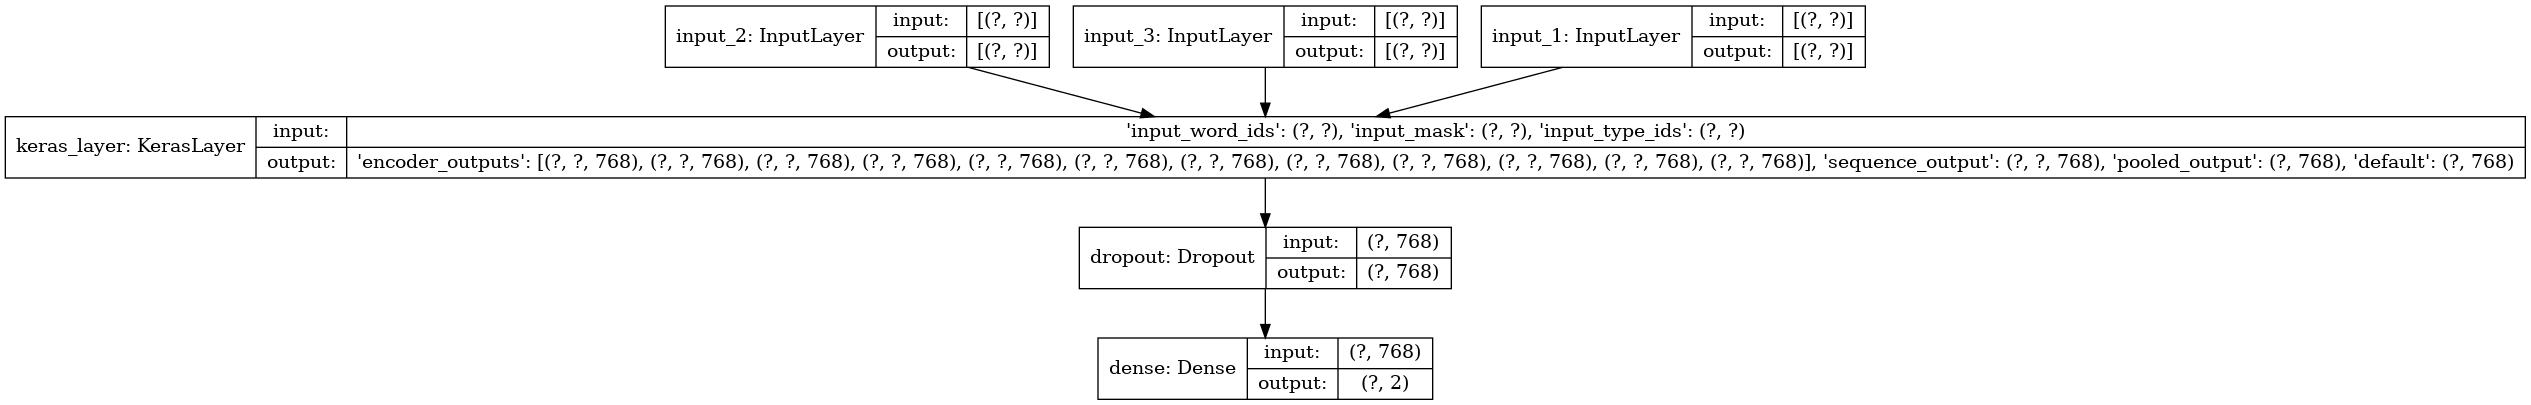

In [22]:
keras.utils.plot_model(model, "Bert_model.png", show_shapes=True)

In [23]:
# Set up epochs and steps
epochs = 3
batch_size = 16
eval_batch_size = 16

train_data_size = len(msrp_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
hist = model.fit(
      msrp_train, msrp_train_labels,
      validation_data=(msrp_test, msrp_test_labels),
      batch_size=16,
      epochs=3)


Epoch 1/3
17601/17601 [==============================] - 5983s 340ms/step - loss: 0.3552 - accuracy: 0.8357 - val_loss: 0.2780 - val_accuracy: 0.8800
Epoch 2/3
17601/17601 [==============================] - 5989s 340ms/step - loss: 0.2149 - accuracy: 0.9116 - val_loss: 0.2569 - val_accuracy: 0.8993
Epoch 3/3
17601/17601 [==============================] - 6038s 343ms/step - loss: 0.1287 - accuracy: 0.9510 - val_loss: 0.2793 - val_accuracy: 0.9010


{'loss': [0.3551918864250183, 0.21487700939178467, 0.12868298590183258], 'accuracy': [0.8357101082801819, 0.9115982055664062, 0.9509573578834534], 'val_loss': [0.2779722213745117, 0.25692230463027954, 0.2793056070804596], 'val_accuracy': [0.8799625039100647, 0.8992656469345093, 0.9009701013565063]}


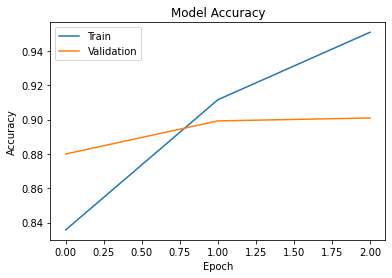

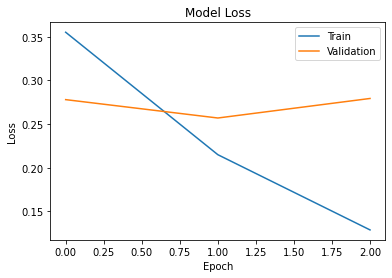

In [25]:
# Plot accuracy
print(hist.history)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [26]:
model.save_weights("results/bert_model_qqp",save_format="h5")

In [27]:
with open('results/bert_model_qqp.json', 'w') as f:
    json.dump(hist.history, f)